In [ ]:
import pandas as pd
import numpy as np
import time, warnings
import datetime as dt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import sklearn.cluster as cluster
%matplotlib inline
import seaborn as sns
warnings.filterwarnings("ignore")

In [2]:
retail_df = pd.read_excel("Online Retail.xlsx")
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


Performing RFM analysis on UK customers alone

In [4]:
retail_uk = retail_df[retail_df['Country'] == 'United Kingdom']
retail_uk.shape

(495478, 8)

In [5]:
# remove cancelled orders
retail_uk = retail_uk[retail_uk['Quantity'] > 0]
retail_uk.shape

(486286, 8)

In [6]:
# remove rows where customerID are NA
retail_uk.dropna(subset = ['CustomerID'],how = 'all',inplace = True)
retail_uk.shape

(354345, 8)

In [7]:
# restrict the data to one full year because it's better to use a metric per Months or Years in RFM
retail_uk = retail_uk[retail_uk['InvoiceDate'] >= "2010-12-09"]
retail_uk.shape

(342478, 8)

In [8]:
retail_uk.describe()

,Quantity,UnitPrice,CustomerID
count,342478.000000,342478.000000,342478.000000
mean,12.097708,2.960558,15543.695437
std,193.498196,18.147268,1591.353278
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,14191.000000
50%,4.000000,1.850000,15511.000000
75%,12.000000,3.750000,16928.000000
max,80995.000000,8142.750000,18287.000000


# RFM Analysis

RFM (**Recency, Frequency, Monetary**) analysis is a customer segmentation technique that uses past purchase **behavior** to divide customers into groups.


## Recency


In [9]:
# last date
retail_uk['InvoiceDate'].max()

Timestamp('2011-12-09 12:49:00')

In [10]:
# the last date we have is 2011-12-09 so we will use it as reference.
now = dt.date(2011,12,9)
print(now)

2011-12-09


In [11]:
# create a new column called date which contains the date of invoice only
retail_uk['date'] = retail_uk['InvoiceDate'].dt.date

In [12]:
retail_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date
19632,537879,22114,HOT WATER BOTTLE TEA AND SYMPATHY,12,2010-12-09 08:34:00,3.95,14243.0,United Kingdom,2010-12-09
19633,537879,22835,HOT WATER BOTTLE I AM SO POORLY,8,2010-12-09 08:34:00,4.65,14243.0,United Kingdom,2010-12-09
19634,537879,85150,LADIES & GENTLEMEN METAL SIGN,6,2010-12-09 08:34:00,2.55,14243.0,United Kingdom,2010-12-09
19635,537879,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,4,2010-12-09 08:34:00,7.95,14243.0,United Kingdom,2010-12-09
19636,537879,21524,DOORMAT SPOTTY HOME SWEET HOME,2,2010-12-09 08:34:00,7.95,14243.0,United Kingdom,2010-12-09


In [13]:
recency_df = retail_uk.groupby(by='CustomerID', as_index = False)['date'].max()
recency_df.columns = ['CustomerID','LastPurshaceDate']
recency_df.head()

,CustomerID,LastPurshaceDate
0,12346.0,2011-01-18
1,12747.0,2011-12-07
2,12748.0,2011-12-09
3,12749.0,2011-12-06
4,12820.0,2011-12-06


In [14]:
recency_df['Recency'] = recency_df['LastPurshaceDate'].apply(lambda x: (now - x).days)

In [15]:
recency_df.head()

,CustomerID,LastPurshaceDate,Recency
0,12346.0,2011-01-18,325
1,12747.0,2011-12-07,2
2,12748.0,2011-12-09,0
3,12749.0,2011-12-06,3
4,12820.0,2011-12-06,3


In [16]:
# dropping LastPurchaseDate 
recency_df.drop('LastPurshaceDate',axis=1,inplace=True)

## Frequency

Frequency helps us to know how many times a customer purchased from us.

In [17]:
# drop duplicates
retail_uk_copy = retail_uk
retail_uk_copy.drop_duplicates(subset=['InvoiceNo', 'CustomerID'], keep = "first", inplace = True)
# calculate frequency of purchases
frequency_df = retail_uk_copy.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()
frequency_df.columns = ['CustomerID','Frequency']
frequency_df.head()

,CustomerID,Frequency
0,12346.0,1
1,12747.0,10
2,12748.0,196
3,12749.0,5
4,12820.0,4


## Monetary

Monetary attribute answers the question: How much money did the customer spent over time?

In [18]:
# create column total cost
retail_uk['TotalCost'] = retail_uk['Quantity'] * retail_uk['UnitPrice']

In [19]:
monetary_df = retail_uk.groupby(by='CustomerID',as_index=False).agg({'TotalCost': 'sum'})
monetary_df.columns = ['CustomerID','Monetary']
monetary_df.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12747.0,658.89
2,12748.0,3739.23
3,12749.0,98.35
4,12820.0,58.20


In [20]:
temp_df = recency_df.merge(frequency_df,on = 'CustomerID')
temp_df.head()

,CustomerID,Recency,Frequency
0,12346.0,325,1
1,12747.0,2,10
2,12748.0,0,196
3,12749.0,3,5
4,12820.0,3,4


In [21]:
rfm_df = temp_df.merge(monetary_df,on = 'CustomerID')
# using CustomerID as index
rfm_df.set_index('CustomerID',inplace=True)
rfm_df.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,10,658.89
12748.0,0,196,3739.23
12749.0,3,5,98.35
12820.0,3,4,58.20


## Customer segments with RFM Model

Pareto’s rule says 20% customers contribute to 80% of your total revenue

### Applying 80-20 rule

In [22]:
pareto_cutoff = rfm_df['Monetary'].sum() * 0.8
print("80% of the total revenue is: ",round(pareto_cutoff,2))

80% of the total revenue is:  890679.54


In [23]:
customers_rank = rfm_df
# create a new column that is the rank of the value of coverage in ascending order
customers_rank['Rank'] = customers_rank['Monetary'].rank(ascending=0)
customers_rank.head()

,Recency,Frequency,Monetary,Rank
CustomerID,,,,
12346.0,325,1,77183.60,2.0
12747.0,2,10,658.89,183.0
12748.0,0,196,3739.23,34.0
12749.0,3,5,98.35,1140.0
12820.0,3,4,58.20,1665.5


### Top Customers

In [24]:
customers_rank.sort_values('Rank',ascending=True)

,Recency,Frequency,Monetary,Rank
CustomerID,,,,
16446.0,0,2,168471.25,1.0
12346.0,325,1,77183.60,2.0
15098.0,182,3,39916.50,3.0
18102.0,0,57,39646.45,4.0
17949.0,1,44,28685.69,5.0
...,...,...,...,...
15503.0,362,1,0.42,3859.5
15645.0,18,1,0.42,3859.5
17914.0,3,1,0.39,3861.5


In [25]:
# get top 20% of the customers
top_20_cutoff = 3863 *20 /100
top_20_cutoff

772.6

In [26]:
# sum the monetary values over the customer with rank <= 772
revenueByTop20 = customers_rank[customers_rank['Rank'] <= 772]['Monetary'].sum()
revenueByTop20

976683.3499999999

More than 80% of total revenue is achieved by the 20% of TOP customers

### Applying RFM score formula

Using quantiles to categorise the data.

In [27]:
quantiles = rfm_df.quantile(q=[0.25,0.5,0.75])
quantiles.to_dict()
quantiles

,Recency,Frequency,Monetary,Rank
0.25,17.0,1.0,17.4,966.5
0.50,49.0,2.0,45.0,1930.5
0.75,134.0,5.0,121.6,2898.0


#### Creation of RFM segmentation table

Creating two segmentation classes as high recency is bad but high frequency and monetary value is good.

In [28]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [29]:
#create rfm segmentation table
rfm_segmentation = rfm_df
rfm_segmentation['R_Quartile'] = rfm_segmentation['Recency'].apply(RScore, args = ('Recency',quantiles,))
rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].apply(FMScore, args = ('Frequency',quantiles,))
rfm_segmentation['M_Quartile'] = rfm_segmentation['Monetary'].apply(FMScore, args = ('Monetary',quantiles,))

In [30]:
rfm_segmentation.head()

,Recency,Frequency,Monetary,Rank,R_Quartile,F_Quartile,M_Quartile
CustomerID,,,,,,,
12346.0,325,1,77183.60,2.0,1,1,4
12747.0,2,10,658.89,183.0,4,4,4
12748.0,0,196,3739.23,34.0,4,4,4
12749.0,3,5,98.35,1140.0,4,3,3
12820.0,3,4,58.20,1665.5,4,3,3


In [31]:
rfm_segmentation['RFMScore'] = rfm_segmentation.R_Quartile.map(str) \
                            + rfm_segmentation.F_Quartile.map(str) \
                            + rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()

,Recency,Frequency,Monetary,Rank,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,,
12346.0,325,1,77183.60,2.0,1,1,4,114
12747.0,2,10,658.89,183.0,4,4,4,444
12748.0,0,196,3739.23,34.0,4,4,4,444
12749.0,3,5,98.35,1140.0,4,3,3,433
12820.0,3,4,58.20,1665.5,4,3,3,433


Best Recency score = 4: most recently purchase.
Best Frequency score = 4: most quantity purchase.
Best Monetary score = 4: spent the most.

Best customers would be 444

In [32]:
rfm_segmentation[rfm_segmentation['RFMScore']=='444'].sort_values('Monetary', ascending=False).head(10)

,Recency,Frequency,Monetary,Rank,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,,
18102.0,0,57,39646.45,4.0,4,4,4,444
17949.0,1,44,28685.69,5.0,4,4,4,444
17450.0,8,44,25953.51,6.0,4,4,4,444
16013.0,3,45,17163.28,8.0,4,4,4,444
16333.0,7,22,14418.96,9.0,4,4,4,444
15769.0,7,25,11660.84,11.0,4,4,4,444
12901.0,8,28,9230.45,12.0,4,4,4,444
13798.0,1,56,7786.26,13.0,4,4,4,444
16684.0,4,28,7700.08,14.0,4,4,4,444


**How many customers do we have in each segment?**

In [33]:
print("Best Customers: ",len(rfm_segmentation[rfm_segmentation['RFMScore'] == '444']))
print('Loyal Customers: ',len(rfm_segmentation[rfm_segmentation['F_Quartile'] == 4]))
print("Big Spenders: ",len(rfm_segmentation[rfm_segmentation['M_Quartile'] == 4]))
print('Lost Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore'] == '144']))
print('Lost Cheap Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore'] == '111']))

Best Customers:  356
Loyal Customers:  752
Big Spenders:  966
Lost Customers:  9
Lost Cheap Customers:  353


Thus we can now include offers for the low customers and give rewards to top customers

## Applying K-means clustering on RFM variables

### Preprocess Data

In [34]:
rfm_data = rfm_df.drop(['R_Quartile','F_Quartile','M_Quartile','RFMScore','Rank'],axis=1)
rfm_data.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,10,658.89
12748.0,0,196,3739.23
12749.0,3,5,98.35
12820.0,3,4,58.20


In [35]:
rfm_data.shape

(3863, 3)

In [36]:
features = rfm_data.columns

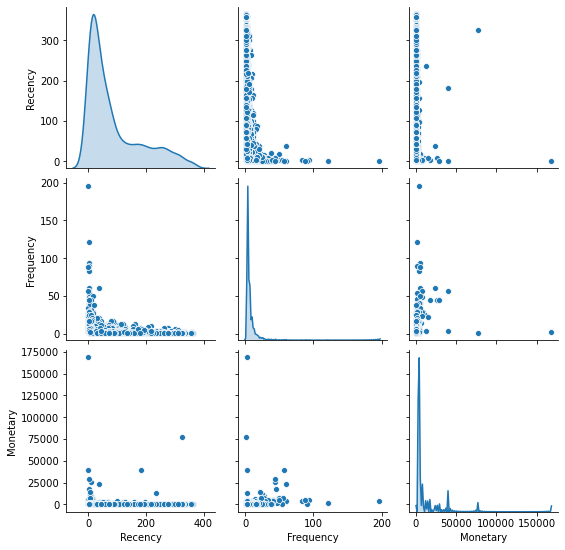

In [37]:
sns.pairplot(rfm_data,diag_kind = 'kde');

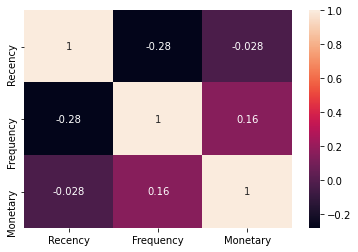

In [38]:
sns.heatmap(rfm_data.corr(),annot = True);

In [39]:
from sklearn.preprocessing import PowerTransformer
# power transformer trasnforms and scales the data
pt = PowerTransformer()
rfm_data = pd.DataFrame(pt.fit_transform(rfm_data), columns = rfm_data.columns)
rfm_data.columns = features
rfm_data.head()

,Recency,Frequency,Monetary
0,1.682373,-1.148472,3.614781
1,-1.735475,1.489108,1.637693
2,-2.225068,2.348818,2.476262
3,-1.592186,0.912985,0.526898
4,-1.592186,0.679845,0.182058


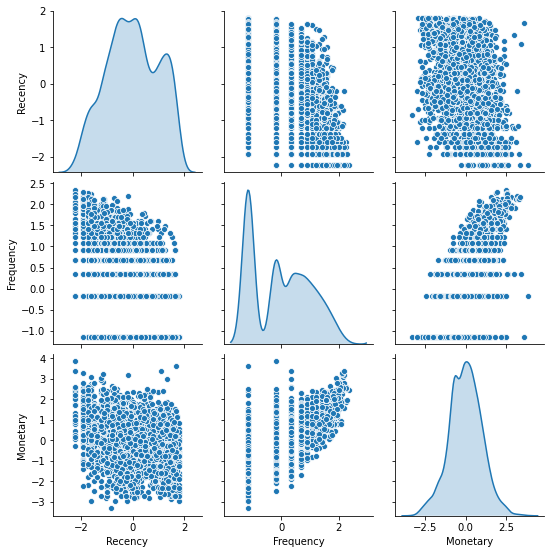

In [40]:
sns.pairplot(rfm_data,diag_kind = 'kde');

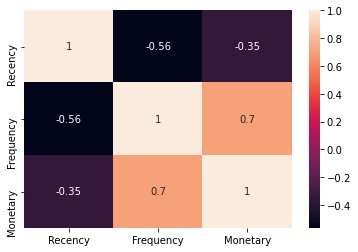

In [41]:
sns.heatmap(rfm_data.corr(),annot = True);
# Monetory and Frequency are positively correlated
# Recency and Frequency are negatively correlated
# Recency and Monetary are negatively correlated


In [42]:
transformed_rfm = rfm_data.copy()

In [43]:
from sklearn.decomposition import PCA
for i in range(1,4):
    pca = PCA(n_components = i)
    df_pca = pca.fit_transform(transformed_rfm)
    variance = pca.explained_variance_ratio_
    print('*' * 50)
    print("Components : ", i)
    print("Variance : ", variance)
    print(sum(variance))

**************************************************
Components :  1
Variance :  [0.69704622]
0.6970462160346029
**************************************************
Components :  2
Variance :  [0.69704622 0.22051142]
0.9175576374490605
**************************************************
Components :  3
Variance :  [0.69704622 0.22051142 0.08244236]
1.0


In [44]:
# 2 PCA captures the variance of 91%
pca = PCA(n_components = 2)
df_pca = pca.fit_transform(transformed_rfm)
df_pca = pd.DataFrame(df_pca, columns = ["PCA 1", "PCA 2"])
df_pca

,PCA 1,PCA 2
0,0.486429,3.327655
1,2.781428,-0.258910
2,4.062671,-0.059704
3,1.701726,-0.861618
4,1.354824,-1.090857
...,...,...
3858,-1.766797,0.822520
3859,-2.208315,-0.182688
3860,0.450608,-1.060602
3861,2.097911,-0.908758


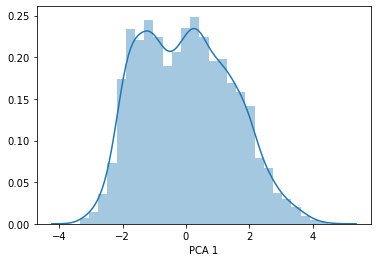

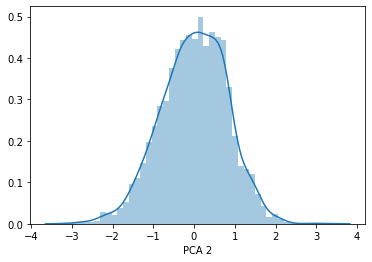

In [45]:
for i in df_pca.columns:
    sns.distplot(df_pca[i]);
    plt.show()

In [46]:
attributes_pca = pd.DataFrame()
for i in range(2):
    attributes_pca['PC'+str(i+1)] = pca.components_[i]
attributes_pca['Attribute'] = transformed_rfm.columns
attributes_pca

,PC1,PC2,Attribute
0,-0.513339,0.802569,Recency
1,0.636446,0.118463,Frequency
2,0.575691,0.584679,Monetary


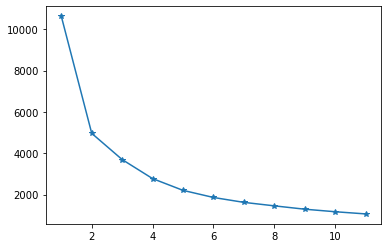

In [47]:
from sklearn.cluster import KMeans
inertia = []
for i in range(1,12):
    kmod = KMeans(n_clusters = i)
    kmod.fit(df_pca)
    inertia.append(kmod.inertia_)
plt.plot(range(1, 12), inertia, '-*');

In [48]:
# cluster is 2 
# confirming with silhouette_score
from sklearn.metrics import silhouette_score
for i in range(2,12):
    kmod = KMeans(n_clusters = i)
    kmod.fit(df_pca)
    labels = kmod.predict(df_pca)
    inertia.append(kmod.inertia_)
    print('*' * 50)
    print("Cluster : ", i)
    print("Silhouette score : ", silhouette_score(df_pca, labels))
# silhouette_score score reduces drastically from 0.44 to 0.35
# thus using cluster number as 2

**************************************************
Cluster :  2
Silhouette score :  0.44534493873070863
**************************************************
Cluster :  3
Silhouette score :  0.35392993984583326
**************************************************
Cluster :  4
Silhouette score :  0.3686071835187863
**************************************************
Cluster :  5
Silhouette score :  0.36150250990167343
**************************************************
Cluster :  6
Silhouette score :  0.3621595031515462
**************************************************
Cluster :  7
Silhouette score :  0.3553961744534634
**************************************************
Cluster :  8
Silhouette score :  0.3479991932017478
**************************************************
Cluster :  9
Silhouette score :  0.352188229201463
**************************************************
Cluster :  10
Silhouette score :  0.35087221802045127
**************************************************
Cluster :  11
Silh

In [49]:
kmod = KMeans(n_clusters = 2, random_state = 0)
kmod.fit(df_pca)
labels = kmod.predict(df_pca)
km_clustered_df = pd.DataFrame(df_pca)
km_clustered_df['Labels'] = labels
km_clustered_df

,PCA 1,PCA 2,Labels
0,0.486429,3.327655,0
1,2.781428,-0.258910,0
2,4.062671,-0.059704,0
3,1.701726,-0.861618,0
4,1.354824,-1.090857,0
...,...,...,...
3858,-1.766797,0.822520,1
3859,-2.208315,-0.182688,1
3860,0.450608,-1.060602,0
3861,2.097911,-0.908758,0


In [50]:
from sklearn.cluster import AgglomerativeClustering
for i in range(2,12):
    agg_mod = AgglomerativeClustering(n_clusters = i, linkage = 'ward')
    agg_labels = agg_mod.fit_predict(df_pca)
    print('*' * 50)
    print("Cluster : ", i)
    print("Silhouette score : ", silhouette_score(df_pca, agg_labels))
# AgglomerativeClustering also states cluster number as 2

**************************************************
Cluster :  2
Silhouette score :  0.4948402739647
**************************************************
Cluster :  3
Silhouette score :  0.39705188856027723
**************************************************
Cluster :  4
Silhouette score :  0.3407091004811667
**************************************************
Cluster :  5
Silhouette score :  0.3388492431583433
**************************************************
Cluster :  6
Silhouette score :  0.33741140053118446
**************************************************
Cluster :  7
Silhouette score :  0.32970888210653154
**************************************************
Cluster :  8
Silhouette score :  0.32473795349438406
**************************************************
Cluster :  9
Silhouette score :  0.30977619200484613
**************************************************
Cluster :  10
Silhouette score :  0.3120338719494026
**************************************************
Cluster :  11
Silho

In [51]:
agg_mod = AgglomerativeClustering(n_clusters = 2, linkage = 'ward')
agg_labels = agg_mod.fit_predict(df_pca)
agg_clustered_df = pd.DataFrame(df_pca)
agg_clustered_df['Labels'] = agg_labels
agg_clustered_df

,PCA 1,PCA 2,Labels
0,0.486429,3.327655,1
1,2.781428,-0.258910,1
2,4.062671,-0.059704,1
3,1.701726,-0.861618,1
4,1.354824,-1.090857,1
...,...,...,...
3858,-1.766797,0.822520,0
3859,-2.208315,-0.182688,0
3860,0.450608,-1.060602,1
3861,2.097911,-0.908758,1


In [52]:
print("Silhouette score for kmeans : ", silhouette_score(df_pca, labels))

print("Silhouette score for agglomerative : ", silhouette_score(df_pca, agg_labels))

Silhouette score for kmeans :  0.4948402739646989
Silhouette score for agglomerative :  0.4948402739646989


Silhouette score for agglomerative is same for kmeans and agglomerative

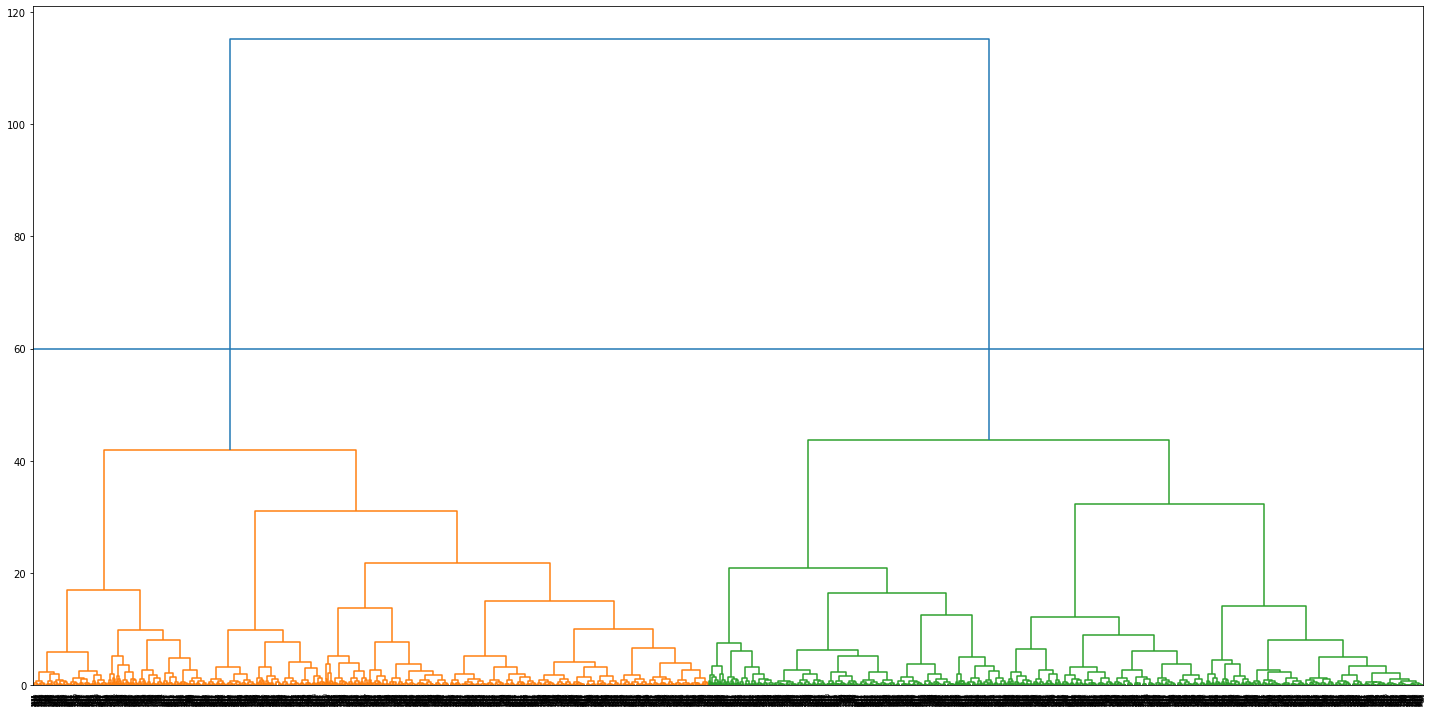

In [53]:
plt.figure(figsize = (20,10))
from scipy.cluster.hierarchy import dendrogram,linkage
link = linkage(df_pca, 'ward')
dendrogram(link)
plt.axhline(60)
plt.tight_layout()

Thus from the dendogram we can see cluster 2 seems to be the right number

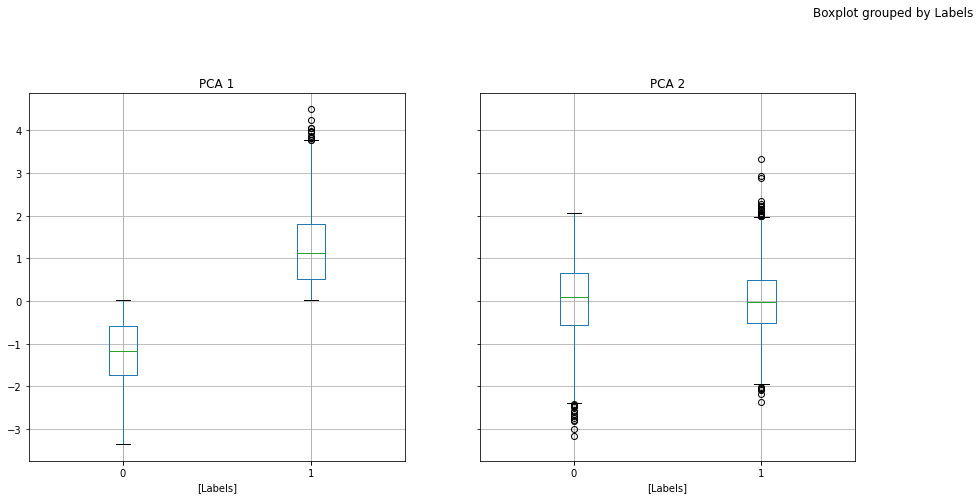

In [54]:
agg_clustered_df.boxplot(by = 'Labels',layout=(2,4), figsize=(30, 15));

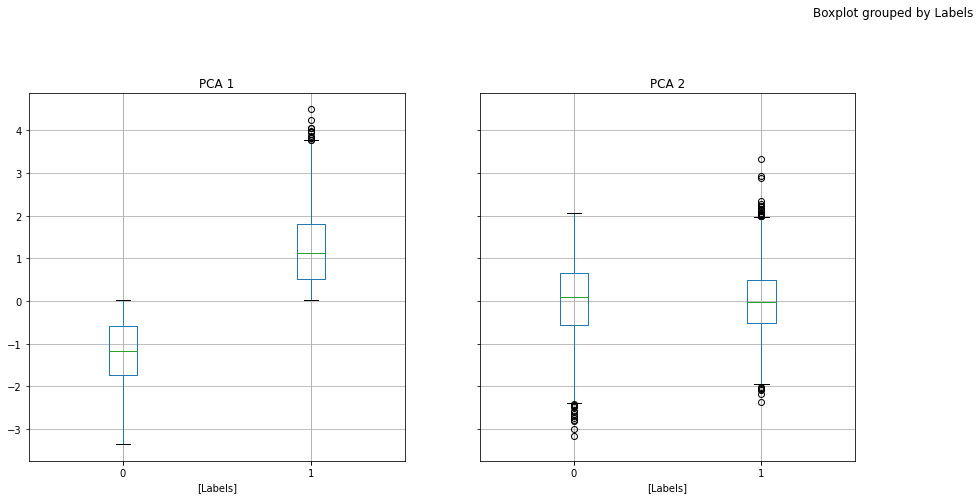

In [55]:
km_clustered_df.boxplot(by = 'Labels',layout=(2,4), figsize=(30, 15));

In [63]:
attributes_pca
# attribute give the load of each columns to the PCA

,PC1,PC2,Attribute
0,-0.513339,0.802569,Recency
1,0.636446,0.118463,Frequency
2,0.575691,0.584679,Monetary


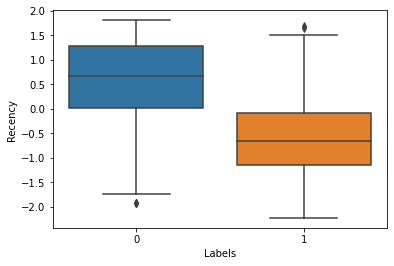

In [56]:
transformed_rfm['Labels'] = agg_labels
sns.boxplot(transformed_rfm['Labels'], transformed_rfm['Recency']);

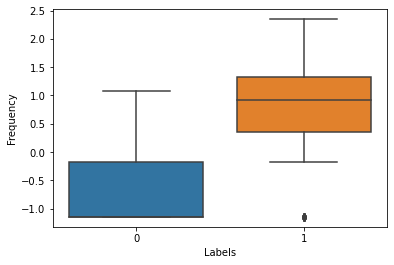

In [57]:
sns.boxplot(transformed_rfm['Labels'], transformed_rfm['Frequency']);

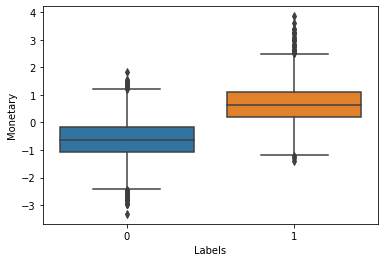

In [58]:
sns.boxplot(transformed_rfm['Labels'], transformed_rfm['Monetary']);

Inference :

1. The customers have been segmented to two groups.

2. Label 0 customers have higher recency and lower frequency and lower monetary when compared to Label 1 customers.

3. Thus Label 1 customers are the group of valuable customers where any promotional offers can be introduced.

4. Label 0 customers are to be focussed a lot by the retail by giving additional discounts and suitable policies.
